# D.3. Inflation

## Markets Foundations

### UChicago Financial Mathematics

#### September 2023

* Mark Hendricks
* hendricks@uchicago.edu

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
from scipy.optimize import fsolve  

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               StrMethodFormatter,
                               AutoMinorLocator)
import sys
sys.path.insert(0, '../cmds')
# from utils import *
from treasury_cmds import *

In [2]:
rawdata = pd.read_excel('../data/economic_data_2023.xlsx',sheet_name='data').set_index('date')

FREQ = 4

if FREQ == 4:
    FREQcode = 'Q'
elif FREQ == 1:
    FREQcode = 'Y'
elif FREQ==12:
    FREQcode = 'M'

data = rawdata.resample(FREQcode).agg('last')
data.index = data.index - pd.tseries.offsets.BDay(1)

data_econ = data

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_11552\1948505432.py:12: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  data = rawdata.resample(FREQcode).agg('last')


# Economic Aggregates

### The dual mandate
The Fed has a dual mandate
- price stability
- full employment

There is a lot of controversey around how the Fed should specifically measure and prioritize these dual goals.

- Traditionally, a view that economic growth and output are related.
- Accordingly, tension in keeping inflation low while also stimulating the economy.

In particular, there is controversey about
- How forcefully should the Fed act with monetary policy to reduce and control inflation? 
- Their primary tool is to raise interest rates.
- Should they risk recession to control inflation?

### The data

The plots below give context about the economy, especially measured discussed relative to interest rates and the Fed.

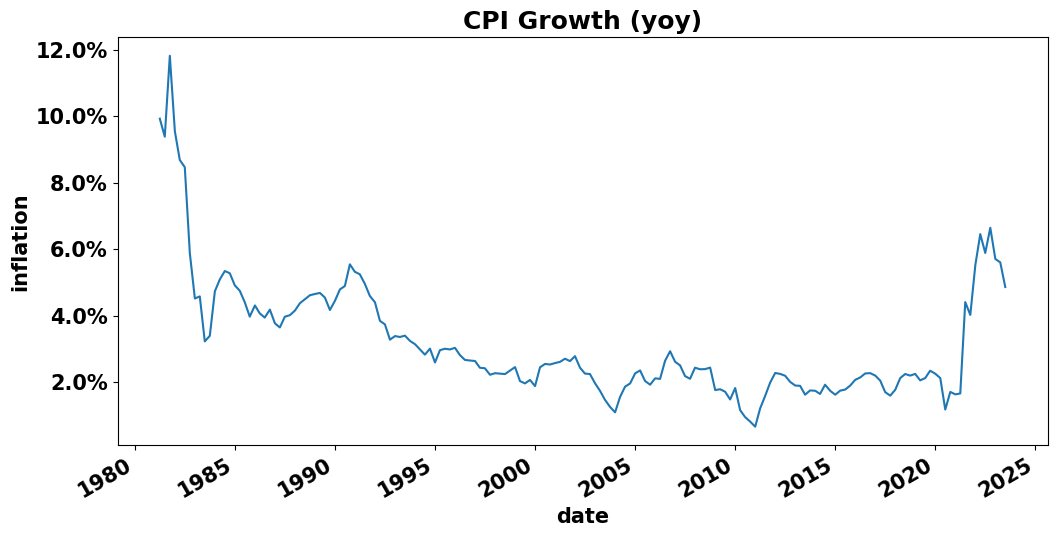

In [3]:
inflation = (data['CPI-Core']/data['CPI-Core'].shift(1) -1 ) * FREQ

inflation_yoy = (data['CPI-Core']/data['CPI-Core'].shift(FREQ) -1 )
ax = inflation_yoy.plot(title='CPI Growth (yoy)',ylabel='inflation')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1%}'))
plt.show()

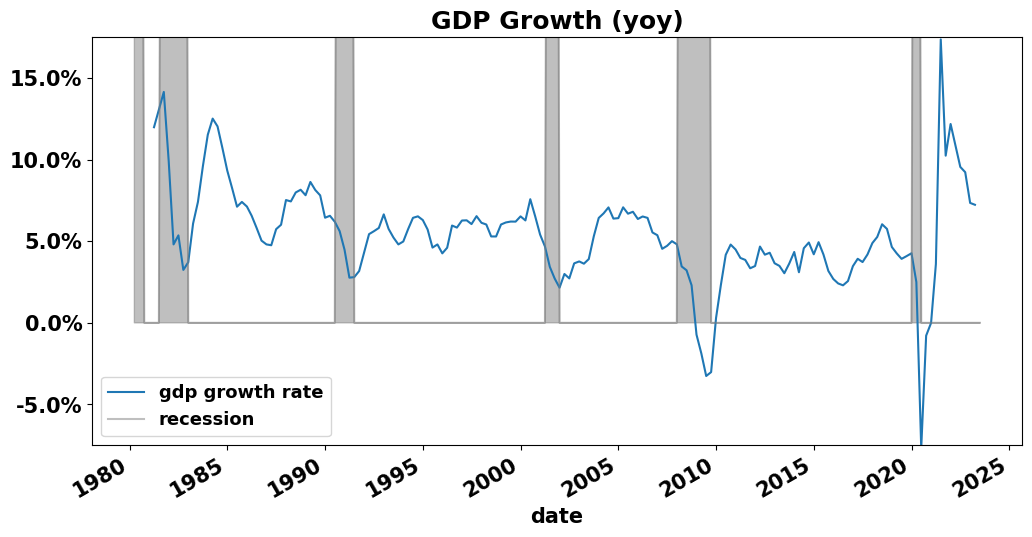

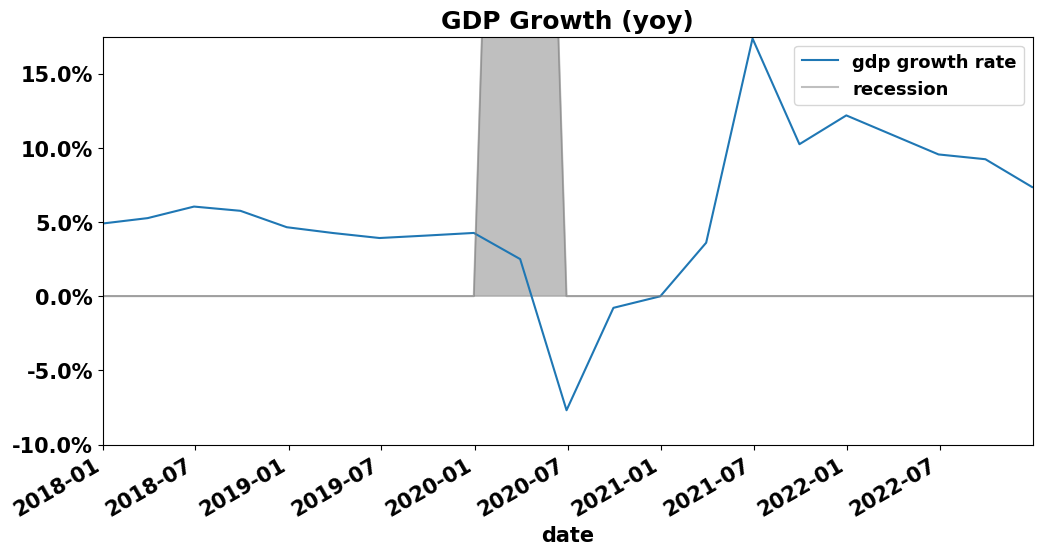

In [4]:
gdp_growth_yoy = (data['GDP'] / data['GDP'].shift(FREQ) - 1)
ax = gdp_growth_yoy.plot()
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1%}'))
data['Recession'].plot.area(ax=ax, alpha=0.5,color='gray')

plt.title('GDP Growth (yoy)')
plt.ylim(-.075,.175)
plt.legend(['gdp growth rate','recession'])
plt.show()

ax = gdp_growth_yoy.plot(title='GDP Growth (yoy)',xlim=('2018-01-01','2022-12-31'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1%}'))
data['Recession'].plot.area(ax=ax, alpha=0.5,color='gray')
plt.ylim(-.10,.175)
plt.legend(['gdp growth rate','recession'])
plt.show()

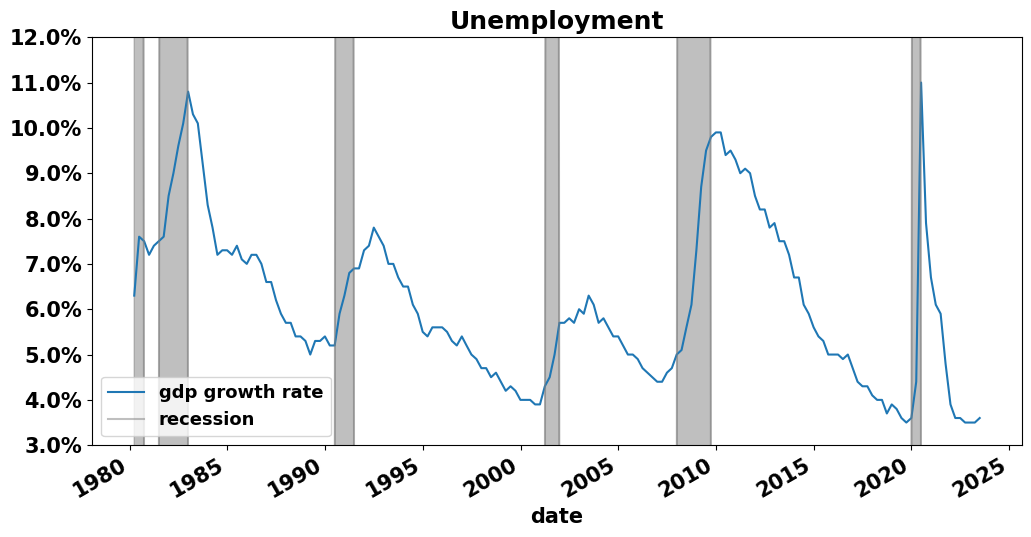

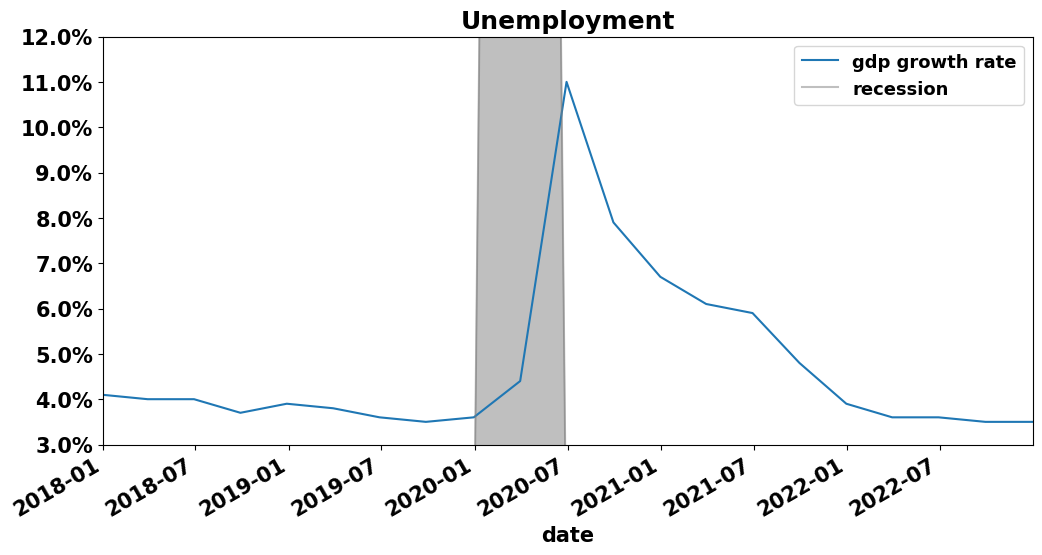

In [5]:
ax = (data['Unemployment']/100).plot()
data['Recession'].plot.area(ax=ax, alpha=0.5,color='gray')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1%}'))

plt.title('Unemployment')
plt.ylim(.03,.12)
plt.legend(['gdp growth rate','recession'])
plt.show()


ax = (data['Unemployment']/100).plot()
data['Recession'].plot.area(ax=ax, alpha=0.5,color='gray')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1%}'))

plt.title('Unemployment')
plt.xlim('2018-01-01','2022-12-31')
plt.ylim(.03,.12)
plt.legend(['gdp growth rate','recession'])
plt.show()

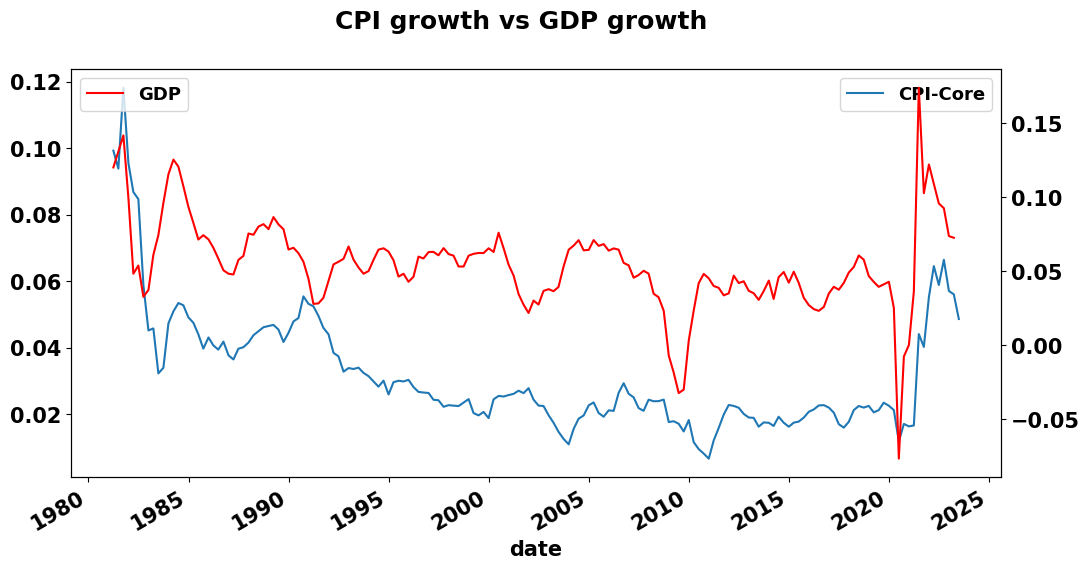

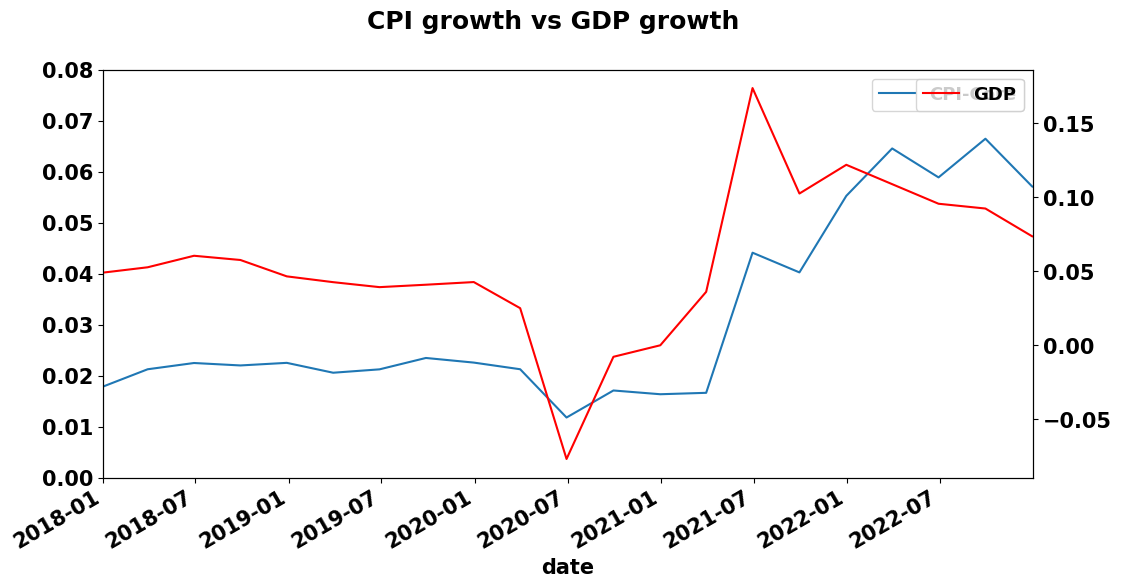

In [6]:
fig,ax = plt.subplots()
inflation_yoy.plot(ax=ax)
ax.legend()

ax2 = ax.twinx()
gdp_growth_yoy.plot(ax=ax2,color='red')
ax2.legend()
fig.suptitle('CPI growth vs GDP growth')
plt.show()



fig,ax = plt.subplots()
inflation_yoy.plot(ax=ax,ylim=(0,.08))
ax.legend()

ax2 = ax.twinx()
gdp_growth_yoy.plot(ax=ax2,color='red',xlim=('2018-01-01','2022-12-31'))
ax2.legend()
fig.suptitle('CPI growth vs GDP growth')
plt.show()

***

# Inflation

Several theories about the determinants of inflation.

- Monetary theory: Money supply (particularly as measured by "M2" money).
- Fiscal theory: Government spending, deficits, debt

Below are a few plots giving context.

### Monetary Theory

Historically, there is a strong correlation between money growth and inflation (with a lag.)

Milton Friedman famously believed that

*Inflation is always and everhwere a monetary phenomenon.*

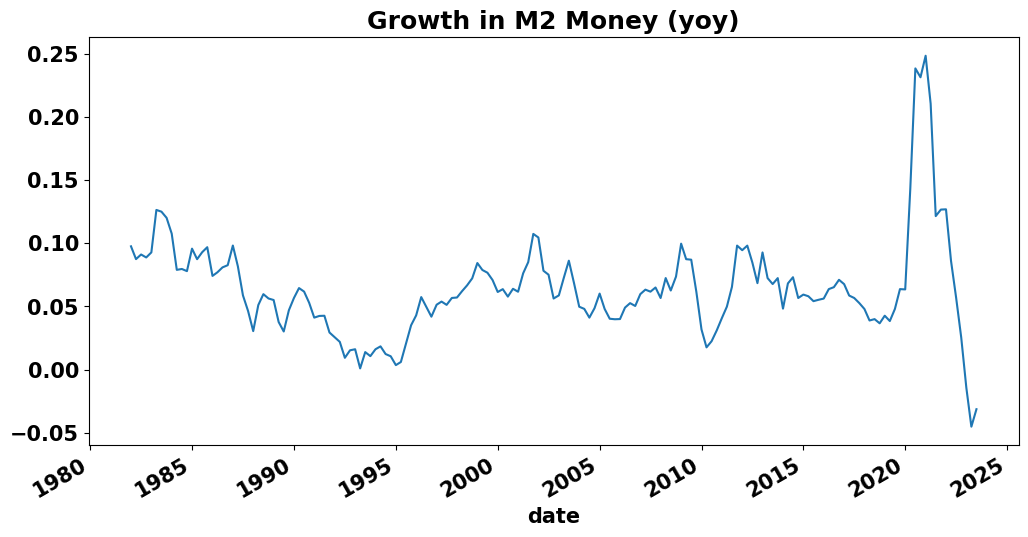

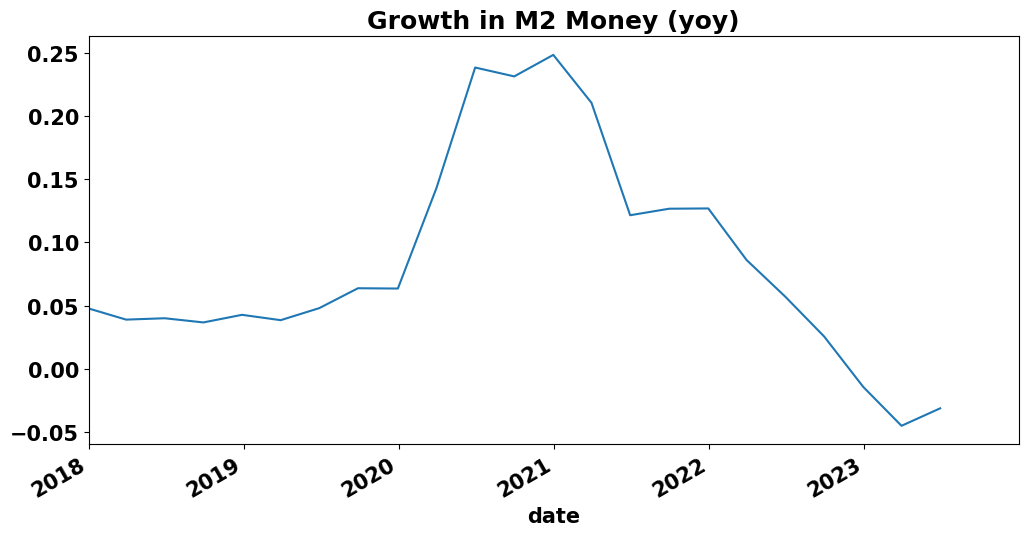

In [7]:
money_growth_yoy = (data['M2 Money']/data['M2 Money'].shift(FREQ)-1)
money_growth_yoy.plot(title='Growth in M2 Money (yoy)')
plt.show()

money_growth_yoy.plot(title='Growth in M2 Money (yoy)',xlim=('2018-01-01','2023-12-31'))
plt.show()

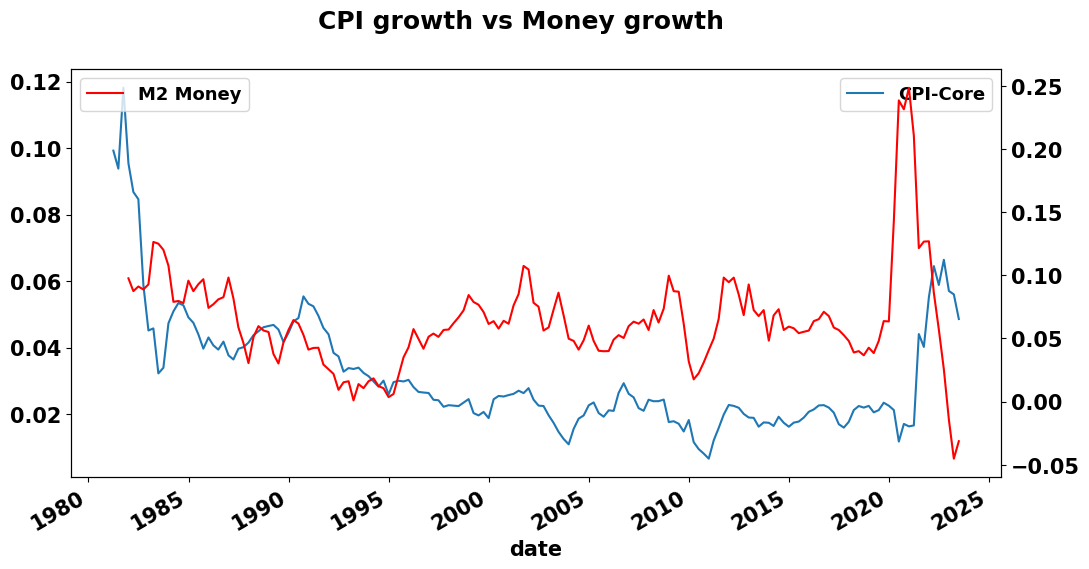

In [8]:
fig,ax = plt.subplots()
inflation_yoy.plot(ax=ax)
ax.legend()

ax2 = ax.twinx()
money_growth_yoy.plot(ax=ax2,color='red')
ax2.legend()
fig.suptitle('CPI growth vs Money growth')
plt.show()

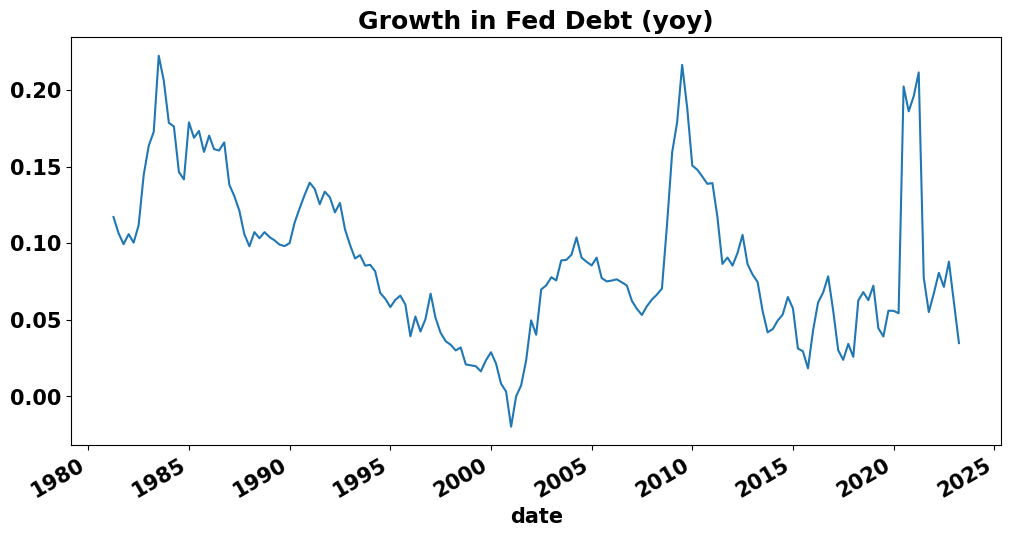

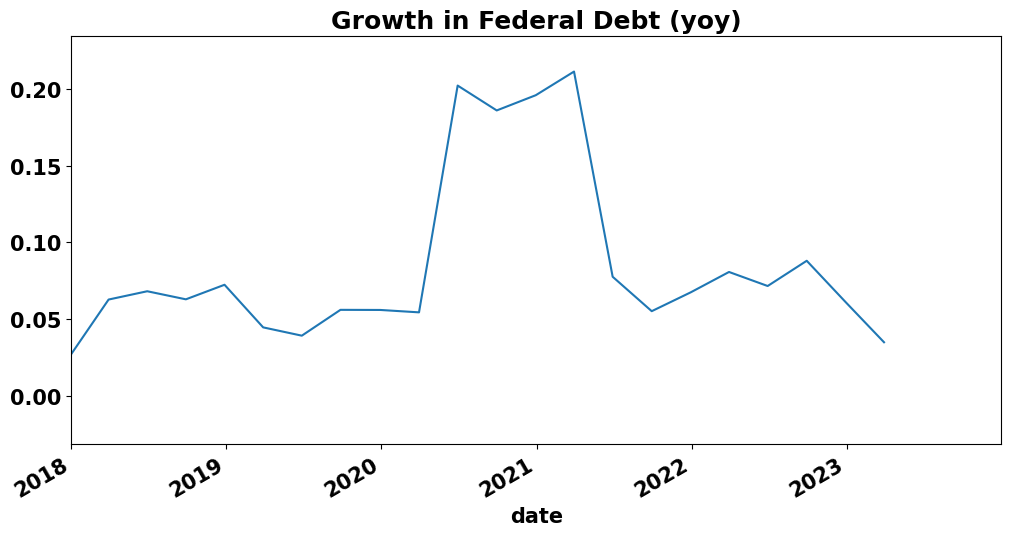

In [9]:
debt_growth_yoy = (data['Federal Public Debt']/data['Federal Public Debt'].shift(FREQ)-1)
debt_growth_yoy.plot(title='Growth in Fed Debt (yoy)')
plt.show()

debt_growth_yoy.plot(title='Growth in Federal Debt (yoy)',xlim=('2018-01-01','2023-12-31'))
plt.show()

# Real Yields

In [10]:
QUOTE_DATE = '2023-06-30'
filepath_rawdata = f'../data/treasury_quotes_{QUOTE_DATE}.xlsx'
rawdata = pd.read_excel(filepath_rawdata,sheet_name='quotes')
rawdata.columns = rawdata.columns.str.upper()
rawdata.sort_values('TMATDT',inplace=True)
rawdata.set_index('KYTREASNO',inplace=True)

t_check = rawdata['CALDT'].values[0]
if rawdata['CALDT'].eq(t_check).all():
    t_current = t_check
else:
    warnings.warn('Quotes are from multiple dates.')
    t_current = None

rawprices = (rawdata['TDBID'] + rawdata['TDASK'])/2 + rawdata['TDACCINT']
rawprices.name = 'price'

maturity_delta = get_maturity_delta(rawdata['TMATDT'],t_current)
maturity_delta.name = 'maturity delta'

metrics = rawdata.copy()[['TDATDT','TMATDT','TDPUBOUT','TCOUPRT','TDYLD','TDDURATN']]
metrics.columns = ['issue date','maturity date','outstanding','coupon rate','yld','duration']
metrics['yld'] *= 365
metrics['duration'] /= 365
metrics['outstanding'] *= 1e6
metrics['maturity interval'] = get_maturity_delta(metrics['maturity date'], t_current)
metrics['price'] = rawprices

display(f'Treasuries quoted on {QUOTE_DATE}.')

'Treasuries quoted on 2023-06-30.'

C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:48: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  temp = pd.date_range(end=maturity_date, periods=np.ceil((maturity_date-quote_date).days/180), freq=pd.DateOffset(months=6))
C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:121: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0625' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  CF.loc[i,coupon_dates] = quote_data.loc[i,'TCOUPRT']/2
C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:48: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a futur

C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:48: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  temp = pd.date_range(end=maturity_date, periods=np.ceil((maturity_date-quote_date).days/180), freq=pd.DateOffset(months=6))
C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:48: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  temp = pd.date_range(end=maturity_date, periods=np.ceil((maturity_date-quote_date).days/180), freq=pd.DateOffset(months=6))
C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:48: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise i

C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:48: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  temp = pd.date_range(end=maturity_date, periods=np.ceil((maturity_date-quote_date).days/180), freq=pd.DateOffset(months=6))
C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:48: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  temp = pd.date_range(end=maturity_date, periods=np.ceil((maturity_date-quote_date).days/180), freq=pd.DateOffset(months=6))
C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:121: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.875' has dtyp

C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:48: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  temp = pd.date_range(end=maturity_date, periods=np.ceil((maturity_date-quote_date).days/180), freq=pd.DateOffset(months=6))
C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:48: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  temp = pd.date_range(end=maturity_date, periods=np.ceil((maturity_date-quote_date).days/180), freq=pd.DateOffset(months=6))
C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:121: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.125' has dtyp

C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:121: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.4375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  CF.loc[i,coupon_dates] = quote_data.loc[i,'TCOUPRT']/2
C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:48: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  temp = pd.date_range(end=maturity_date, periods=np.ceil((maturity_date-quote_date).days/180), freq=pd.DateOffset(months=6))
C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:121: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.1875' has dtype incomp

C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:121: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  CF.loc[i,coupon_dates] = quote_data.loc[i,'TCOUPRT']/2
C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:48: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  temp = pd.date_range(end=maturity_date, periods=np.ceil((maturity_date-quote_date).days/180), freq=pd.DateOffset(months=6))
C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:121: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.4375' has dtype incomp

C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:48: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  temp = pd.date_range(end=maturity_date, periods=np.ceil((maturity_date-quote_date).days/180), freq=pd.DateOffset(months=6))
C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:121: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.1875' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  CF.loc[i,coupon_dates] = quote_data.loc[i,'TCOUPRT']/2
C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:48: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a futur

C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:121: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.125' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  CF.loc[i,coupon_dates] = quote_data.loc[i,'TCOUPRT']/2
C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:48: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  temp = pd.date_range(end=maturity_date, periods=np.ceil((maturity_date-quote_date).days/180), freq=pd.DateOffset(months=6))
C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:48: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future

C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:48: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  temp = pd.date_range(end=maturity_date, periods=np.ceil((maturity_date-quote_date).days/180), freq=pd.DateOffset(months=6))
C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:121: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  CF.loc[i,coupon_dates] = quote_data.loc[i,'TCOUPRT']/2
C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:48: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future

C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:121: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.8125' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  CF.loc[i,coupon_dates] = quote_data.loc[i,'TCOUPRT']/2
C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:48: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  temp = pd.date_range(end=maturity_date, periods=np.ceil((maturity_date-quote_date).days/180), freq=pd.DateOffset(months=6))
C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:121: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.6875' has dtype incomp

C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:121: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.125' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  CF.loc[i,coupon_dates] = quote_data.loc[i,'TCOUPRT']/2
C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:48: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  temp = pd.date_range(end=maturity_date, periods=np.ceil((maturity_date-quote_date).days/180), freq=pd.DateOffset(months=6))
C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:121: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.4375' has dtype incompa

C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:121: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  CF.loc[i,coupon_dates] = quote_data.loc[i,'TCOUPRT']/2
C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:48: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  temp = pd.date_range(end=maturity_date, periods=np.ceil((maturity_date-quote_date).days/180), freq=pd.DateOffset(months=6))
C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:121: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.6875' has dtype incompati

C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:121: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.625' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  CF.loc[i,coupon_dates] = quote_data.loc[i,'TCOUPRT']/2
C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:48: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  temp = pd.date_range(end=maturity_date, periods=np.ceil((maturity_date-quote_date).days/180), freq=pd.DateOffset(months=6))
C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:121: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6875' has dtype incompa

C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:121: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.125' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  CF.loc[i,coupon_dates] = quote_data.loc[i,'TCOUPRT']/2
C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:121: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.125' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  CF.loc[i,coupon_dates] = quote_data.loc[i,'TCOUPRT']/2
C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:48: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.


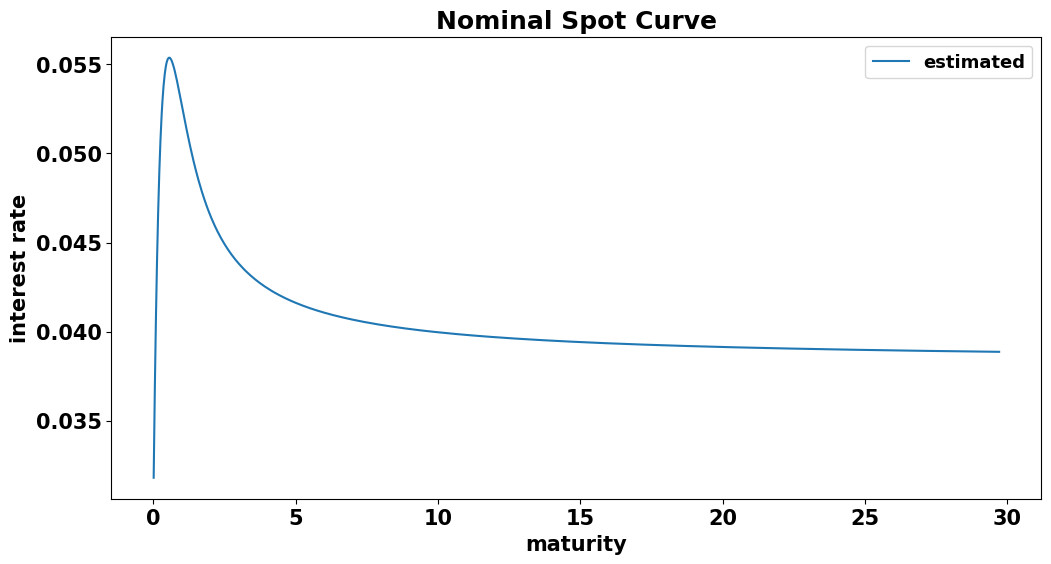

In [11]:
MODEL = bootstrap

RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = False
RESTRICT_REDUNDANT = False

data = filter_treasuries(rawdata, t_date=t_current, filter_yld = RESTRICT_YLD, filter_tips = RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)

CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)

prices = metrics['price'][CF.index]

params = estimate_rate_curve(nelson_siegel,CF,t_current,prices)
if MODEL == nelson_siegel_extended:
    x0 = np.concatenate((params_NS,(1,1)))
    params = estimate_rate_curve(nelson_siegel_extended,CF,t_current,prices,x0=x0)

maturity_grid = get_maturity_delta(CF.columns,t_current)
curve = nelson_siegel(params,maturity_grid)

curves_nominal = pd.DataFrame(index = maturity_grid)
if MODEL == nelson_siegel_extended:
    curves_nominal['estimated']= nelson_siegel_extended(params,maturity_grid)
else:
    curves_nominal['estimated'] = nelson_siegel(params,maturity_grid)

curves_nominal.plot(xlabel='maturity',ylabel='interest rate',title='Nominal Spot Curve')
plt.show()

C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:48: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  temp = pd.date_range(end=maturity_date, periods=np.ceil((maturity_date-quote_date).days/180), freq=pd.DateOffset(months=6))
C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:121: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1875' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  CF.loc[i,coupon_dates] = quote_data.loc[i,'TCOUPRT']/2
C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:48: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a futur

C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:121: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.43750000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  CF.loc[i,coupon_dates] = quote_data.loc[i,'TCOUPRT']/2
C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:48: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  temp = pd.date_range(end=maturity_date, periods=np.ceil((maturity_date-quote_date).days/180), freq=pd.DateOffset(months=6))
C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:121: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dt

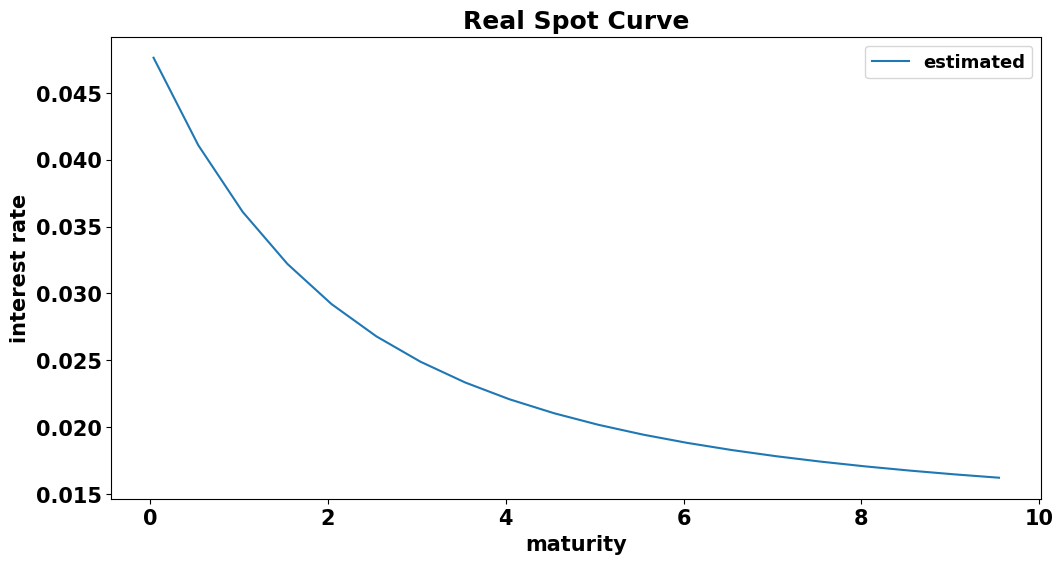

In [12]:
MODEL = nelson_siegel

RESTRICT_YLD = False
RESTRICT_TIPS = False

RESTRICT_DTS_MATURING = True
RESTRICT_REDUNDANT = False

data = filter_treasuries(rawdata, t_date=t_current, filter_yld = RESTRICT_YLD, filter_tips = RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)

CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)

prices = metrics['price'][CF.index]

if MODEL == bootstrap:
        params = estimate_rate_curve(MODEL,CF,t_current,prices)
        
params = estimate_rate_curve(nelson_siegel,CF,t_current,prices)
if MODEL == nelson_siegel_extended:
    x0 = np.concatenate((params,(1,1)))
    params = estimate_rate_curve(nelson_siegel_extended,CF,t_current,prices,x0=x0)

maturity_grid = get_maturity_delta(CF.columns,t_current)
curve = MODEL(params,maturity_grid)

curves_tips = pd.DataFrame(index = maturity_grid)
curves_tips['estimated']= MODEL(params,maturity_grid)

curves_tips.plot(xlabel='maturity',ylabel='interest rate',title='Real Spot Curve')
plt.show()

C:\Users\Jeremy\GitRepositories\finm-markets-2023\discussions\../cmds\treasury_cmds.py:502: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val = sum([cfi/(1+rate)**(maturities[i]) for i, cfi in enumerate(temp)])


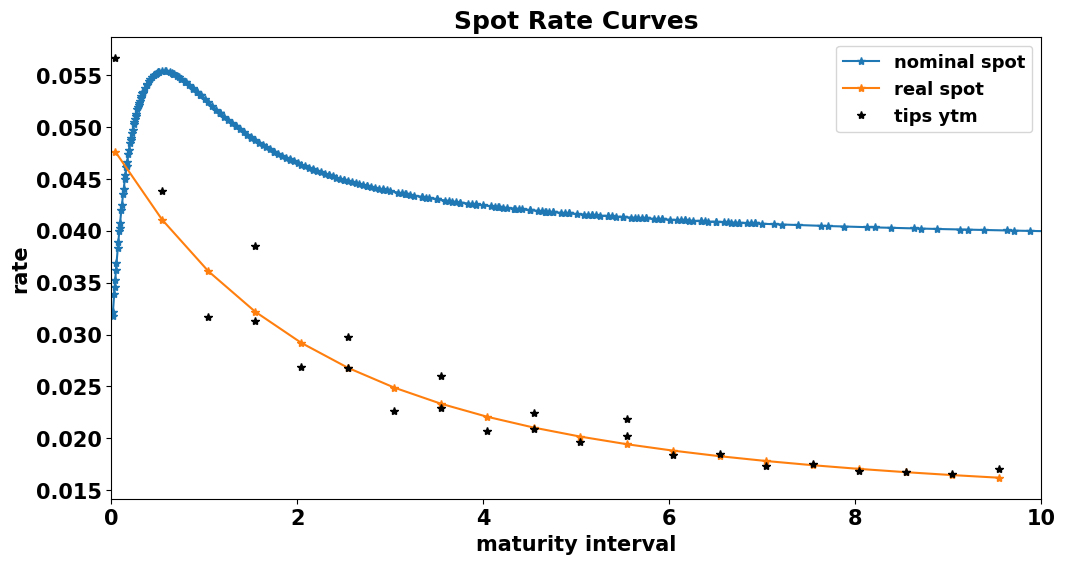

In [13]:
mets = metrics.loc[data.index,:]
mat_interval = pd.Series(index=CF.columns, data=get_maturity_delta(CF.columns,t_current=t_current))

ytm = pd.Series(index = CF.index,dtype=float)

for idx in CF.index:
    ytm.loc[idx] = fsolve(calc_npv,.01,args=(CF.loc[idx,:],mat_interval,prices.loc[idx]))[0]


ytm.name = 'ytm'
tips_ytm = mets[['maturity interval']].join(ytm).set_index('maturity interval')

fig, ax = plt.subplots()
curves_nominal.plot(ax=ax,linestyle='-',marker='*')
curves_tips.plot(ax=ax,linestyle='-',marker='*')
tips_ytm.plot(ax=ax, marker='*',linestyle='',color='k',title='Spot Rate Curves',ylabel='rate')
plt.xlim(0,10)
plt.legend(['nominal spot','real spot','tips ytm'])
plt.show()

In [14]:
# filepath_tsdata = '../data/treasury_ts_issue_TIPS_(207431, 206999, 207009).xlsx'
# tsdata = pd.read_excel(filepath_tsdata,sheet_name='ts')

# tsdata.columns = tsdata.columns.str.upper()
# ts_tips_px = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDASK')
# ts_tips_yld = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDYLD') * 365

# matdts = rawdata.loc[ts_tips_px.columns,'TMATDT']

# taus = pd.DataFrame(index=ts_tips_px.index, columns=ts_tips_px.columns,dtype=float)
# for t in ts_tips_px.index:
#     taus.loc[t,:] = get_maturity_delta(rawdata.loc[ts_tips_px.columns,'TMATDT'],t)

# with warnings.catch_warnings():
#     warnings.simplefilter('ignore')
        
#     ts_tips_yld_approx = -np.log(ts_tips_px/100) / taus

# cpns = rawdata.loc[ts_tips_yld_approx.columns,'TCOUPRT']/100
# ts_tips_yld_approx += cpns

# ts_tips_yld = pd.concat([ts_tips_yld,ts_tips_yld_approx.iloc[:,:]],axis=1)

In [15]:
# labels_leg = list()
# for idx in ts_tips_yld.columns:
#     cpn = rawdata.loc[idx,'TCOUPRT']/100
#     matdt = rawdata.loc[idx,'TMATDT']
#     labels_leg.append(f'coupon {cpn:.2%} maturing on {matdt:%Y-%m-%d}')

# ts_tips_yld.iloc[:,[1,2]].plot(ylabel='yield to maturity',title='YTM for TIPS and Nominal')
# plt.legend(labels_leg)
# plt.show()

In [16]:
# (ts_tips_yld.iloc[:,2]-ts_tips_yld.iloc[:,1]).plot(ylabel='nominal over TIPS spread',title='Breakeven')
# plt.show()

## Market Expectations

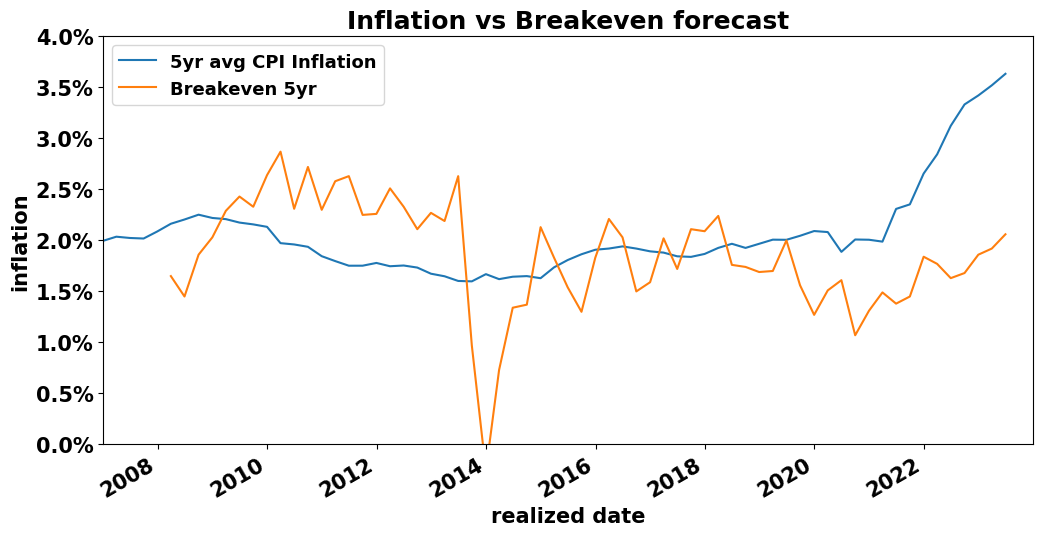

In [17]:
inflation_expectations = pd.concat([inflation.rolling(FREQ*5).mean(), (data_econ['Breakeven 5yr']/100).shift(5*FREQ)],axis=1)
inflation_expectations.rename(columns={'CPI-Core':'5yr avg CPI Inflation'},inplace=True)
ax = inflation_expectations.plot(xlim=('2007-01-01','2023-12-31'),ylim=(0,.04),xlabel='realized date',ylabel='inflation',title='Inflation vs Breakeven forecast')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1%}'))
plt.show()

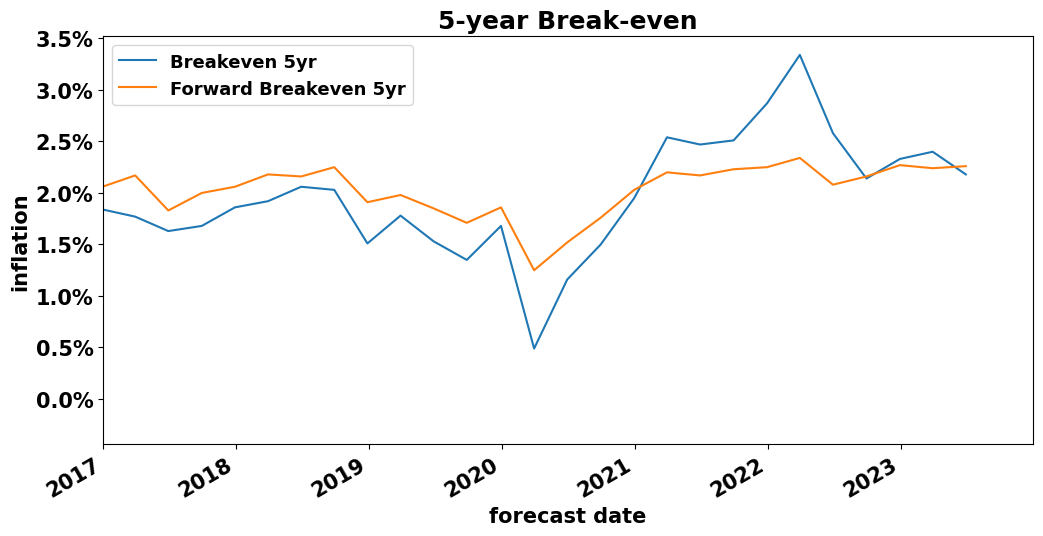

In [18]:
ax = (data_econ[['Breakeven 5yr','Forward Breakeven 5yr']]/100).plot(title='5-year Break-even',xlim=('2017-01-01','2023-12-31'),xlabel='forecast date',ylabel='inflation')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1%}'))
plt.show()